# Including 'Hofstadter SP with Theta Phases' and 'First Band Approximation' Functions

In [1]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Theta Space.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Initial Parameters

In [147]:
Nx=4;Ny=4;N=Nx*Ny
p=1;q=Ny;alpha=p/q
PN=[0,1]
cut_off=4
U = 2
T_size=10;

# Single Particle

In [148]:
function Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty)
    
    N = Nx*Ny
    
    H_T = HSP_T(Nx, Ny, alpha, Tx, Ty, 0)
    
    H = SparseOperator(sp_basis)
    
    for m in 1:N
        for n in 1:N
            H = H + H_T[m,n] * transition(sp_basis, m, n)
        end
    end
    
    return H
end

Sp_Theta_Op (generic function with 1 method)

In [149]:
using LinearAlgebra
eigvals(HSP_T(Nx, Ny, p/q, 1, 1, 0))
# Dejenerelik Tx ve Ty değerine bağlı değil, yani cut-off değerinden bağımsızdır.

16-element Vector{Float64}:
 -2.786240875224423
 -2.786240875224423
 -2.7862408752244225
 -2.786240875224422
 -0.4866844822147538
 -0.48668448221475324
 -0.4866844822147532
 -0.4866844822147515
  0.4866844822147522
  0.4866844822147528
  0.48668448221475297
  0.48668448221475397
  2.786240875224422
  2.7862408752244234
  2.7862408752244234
  2.786240875224424

# MB

In [150]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [151]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN);

# Total Hamiltonian

In [152]:
sp_basis = NLevelBasis(N)
function get_total_H(Nx, Ny, alpha, sp_basis, Tx, Ty, cut_off, PN, basis_cut_sp, basis_cut_mb)
    H1 = Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty)
    sub_states = get_sub_states(H1, cut_off)
    basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
    H1_sub = get_subspace_op(H1, P, Pt)
    states_mb = bosonstates(basis_sub, PN)     
    basis_mb = ManyBodyBasis(basis_sub, states_mb)
    H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub)
    H1cut = SparseOperator(basis_cut_mb)
    H1cut.data = H1_MB.data
    H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off)
    return H1cut + H_Int
end

get_total_H (generic function with 1 method)

In [153]:
x = get_total_H(Nx, Ny, alpha, sp_basis, 0, 0, cut_off, PN, basis_cut_sp, basis_cut_mb)
eigenenergies(dense(x+dagger(x))/2)

5-element Vector{Float64}:
 -2.8284271247461903
 -2.8284271247461903
 -2.8284271247461894
 -2.8284271247461876
  0.0

# CHERN CALCULATION SECTION

In [154]:
dx=2*pi/T_size
dy=dx
Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
Ty=collect(range(start=0, stop=2*pi-dy, step=dy));

In [155]:
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, 1, 1, cut_off, PN, basis_cut_sp, basis_cut_mb);
eigenenergies(dense((H_Total+dagger(H_Total))/2))
eigenstates(dense((H_Total+dagger(H_Total))/2));

In [156]:
function get_Matrix_form(basis_cut_mb, H_total)
    HH_total_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            HH_total_Matrix[i,j] = ((H_total+dagger(H_total))/2).data[i,j]
        end
    end
    return HH_total_Matrix
end
H_total_Matrix

5×5 Matrix{ComplexF64}:
 0.0+0.0im           0.0+0.0im          …           0.0+0.0im
 0.0+0.0im      -2.78624+0.0im              1.38778e-17-1.30104e-16im
 0.0+0.0im   6.93889e-16+1.11022e-16im      1.38778e-17+7.63278e-17im
 0.0+0.0im  -1.66533e-16-8.32667e-17im     -4.85723e-17-2.77556e-17im
 0.0+0.0im   1.38778e-17+1.30104e-16im         -2.78624+0.0im

In [157]:
H_total_Matrix = get_Matrix_form(basis_cut_mb, H_Total)
E = eigvals(H_total_Matrix)
# Matrix form of eigen-states
UU = eigvecs(H_total_Matrix);
E

5-element Vector{Float64}:
 -2.786240875224424
 -2.786240875224422
 -2.786240875224421
 -2.786240875224421
  0.0

In [158]:
PN

2-element Vector{Int64}:
 0
 1

In [159]:
using DataFrames

function get_filtered_energies(pn, basis, H_total)
    # Operator form of eigenstates:
    E, UUU = eigenstates(dense(dense((H_total+dagger(H_total))/2)))
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), UUU[i]))
        PN_Energies[i,2] = E[i]
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_filtered_energies (generic function with 1 method)

In [160]:
pn = 1.0
df = get_filtered_energies(pn, basis_cut_mb, H_Total)
filtered_energies = Matrix(df)[:,2]

4-element Vector{Float64}:
 -2.786240875224424
 -2.786240875224422
 -2.786240875224421
 -2.786240875224421

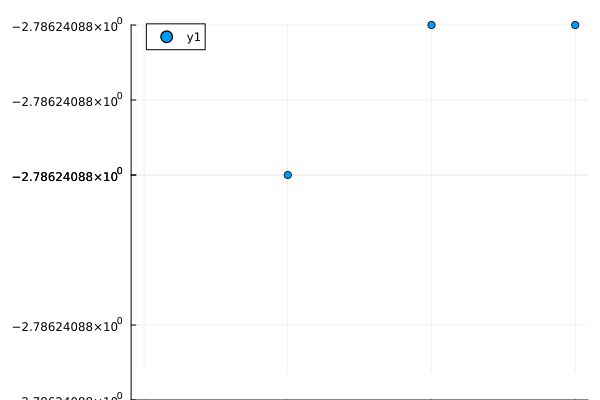

In [166]:
using Plots
plot(1:length(filtered_energies),filtered_energies,seriestype=:scatter)

In [162]:
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[:,1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [188]:
using LinearAlgebra
pn = 1
function get_eigenstates(basis_cut_mb, H_Total, pn)
    
    H_total_Matrix = get_Matrix_form(basis_cut_mb, H_Total)
    E = eigvals(H_total_Matrix)
    UU = eigvecs(H_total_Matrix)
    df = get_filtered_energies(pn, basis_cut_mb, H_Total)
    filtered_energies = Matrix(df)[:,2]
    r_hubbard_states = Restricted_Hubbard_States(UU);
    
    return filtered_energies, r_hubbard_states
end
filtered_energies, r_hubbard_states = get_eigenstates(basis_cut_mb, H_Total, pn)
a = r_hubbard_states[:,3]
b = r_hubbard_states[:,4]
dot(a,b)

1.1102230246251565e-16 + 5.551115123125783e-17im

In [164]:
function Chern_Nums(n1, n2)
    
    Sum=0
    
    for tx in range(start=1, stop=length(Tx))
        for ty in range(start=1, stop=length(Ty))
            
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w1, v1 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            # sorting eigenvalues
            i = sortperm(w1, by=real);w1 = w1[i]
            # sorting eigenstates
            v1 = v1[:,i]
            # multiplet eigenstates
            v1 = v1[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w2, v2 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            i = sortperm(w2, by=real);w2 = w2[i]
            v2 = v2[:,i]
            v2 = v2[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w3, v3 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            i = sortperm(w3, by=real);w3 = w3[i]
            v3 = v3[:,i]
            v3 = v3[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w4, v4 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            i = sortperm(w4, by=real);w4 = w4[i]
            v4 = v4[:,i]
            v4 = v4[:,n1:n2]
            
            #----------LINK VARIABLES------------
            U1=det(adjoint(v1)*v2)
            U1=U1/abs(U1)
            U2=det(adjoint(v2)*v4)
            U2=U2/abs(U2)
            U3=det(adjoint(v3)*v4)
            U3=U3/abs(U3)
            U4=det(adjoint(v1)*v3)
            U4=U4/abs(U4)
            
            #----------BERRY CURVATURE-----------
            F=log(U1*U2*1/U3*1/U4)
            Sum=Sum+F
            
        end
    end
    
    return 1/(2*pi*1im)*Sum
end

Chern_Nums (generic function with 1 method)

In [165]:
Chern_Nums(1, 4)

-9.720567872071721e-17 - 2.4737647522494017e-16im